# **Setup**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset

from torchvision import transforms, datasets
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import plotly.express as px

import seaborn as sns

from skimage import io, transform
import zipfile
import pandas as pd
import torchvision
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ",device)

Device :  cuda


# **Preprocessing**

In [ ]:
zip_path = "/content/archive (4).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
labels_list = []
valid_images_to_continue_with = []
invalid_images = 0
categories_name = {}

def check_valid_images_all_folders(directory):
    global invalid_images
    for i, folder in enumerate(os.listdir(directory)):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            categories_name[folder] = 0
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        invalid_images += 1
                    else:
                        valid_images_to_continue_with.append(img)
                        labels_list.append(folder)
                        categories_name[folder] += 1
                except:
                    invalid_images += 1

check_valid_images_all_folders('/content/PlantVillage')

In [ ]:
label_mapping = {label: i for i, label in enumerate(set(labels_list))}
labels_list_int = [label_mapping[label] for label in labels_list]

In [ ]:
print(label_mapping)

{'Tomato__Target_Spot': 0, 'Tomato_Early_blight': 1, 'Tomato_Leaf_Mold': 2, 'Tomato_Bacterial_spot': 3, 'Potato___Early_blight': 4, 'Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Tomato_Septoria_leaf_spot': 6, 'Tomato_healthy': 7, 'Potato___healthy': 8, 'Tomato__Tomato_mosaic_virus': 9, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 10, 'Pepper__bell___healthy': 11, 'Potato___Late_blight': 12, 'Pepper__bell___Bacterial_spot': 13, 'Tomato_Late_blight': 14}


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64), antialias=True)
])

In [ ]:
class PlantVillageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
dataset = PlantVillageDataset(valid_images_to_continue_with, labels_list_int, transform=transform)
indices = list(range(len(dataset)))
train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 60-20-20

In [ ]:
trainloader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
valloader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)
testloader = DataLoader(Subset(dataset, test_idx), batch_size=16, shuffle=False)

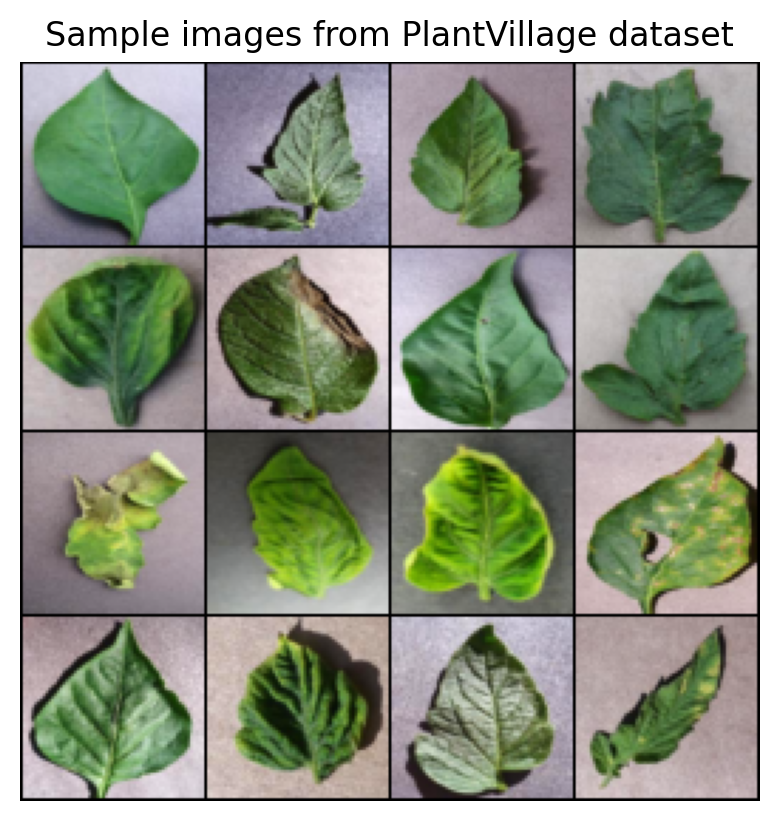

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = make_grid(images[:16], nrow=4, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)

plt.figure(dpi=200)
plt.title("Sample images from PlantVillage dataset")
plt.imshow(grid)
plt.axis('off')
plt.show()

# **Classifier**

In [ ]:
class Classifier(nn.Module):

  def __init__(self, in_features):

    super(Classifier,self).__init__()

    self.FullyConnectedBlock = nn.Sequential(
        nn.Linear(in_features,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,15)
    )

  def forward(self,x):

    output = self.FullyConnectedBlock(x)

    return output

In [ ]:
def train_classifier(dataloader,classifier,model,optimizer,loss_function,ae_type = 'normal'):

  num_batches = len(dataloader)
  classifier.train(True)

  train_loss = 0

  for batch, (X,y) in enumerate(dataloader):

    optimizer.zero_grad()

    X,y = X.to(device), y.to(device)

    with torch.no_grad():

      if ae_type == 'normal':

        Z,_ = model(X)

      else:

        Z,_,_,_ = model(X)

    prediction = classifier(Z)


    loss = loss_function(prediction,y)
    train_loss += loss.item()


    loss.backward()


    optimizer.step()

  train_loss = train_loss / num_batches

  return train_loss

In [ ]:
def validation_classifier(dataloader,classifier,model,loss_function,ae_type = 'normal'):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)


  classifier.eval()

  val_loss = 0

  val_correct = 0

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):


      X,y = X.to(device), y.to(device)

      with torch.no_grad():

        if ae_type == 'normal':

          Z,_ = model(X)

        else:

          Z,_,_,_ = model(X)

      prediction = classifier(Z)

      loss = loss_function(prediction,y)
      val_loss += loss.item()

      val_correct += (prediction.argmax(1) == y).sum().item()

  val_loss = val_loss / num_batches

  val_accuracy = val_correct / size

  return val_loss, val_accuracy

In [ ]:
def test_classifier(dataloader,classifier,model,loss_function,ae_type = 'normal'):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)

  model.eval()

  test_loss = 0

  test_correct = 0

  test_ground_truths = []

  test_predictions = []

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)

      test_ground_truths.append(list(y.cpu().numpy()))

      with torch.no_grad():

        if ae_type == 'normal':

          Z,_ = model(X)

        else:

          Z,_,_,_ = model(X)


      prediction = classifier(Z)

      test_predictions.extend(list(torch.argmax(prediction,1).cpu().numpy()))

      loss = loss_function(prediction,y)

      test_loss += loss.item()

      test_correct += (torch.argmax(prediction,1) == y).sum().item()

  test_loss = test_loss / num_batches


  test_accuracy = test_correct / size

  return test_loss, test_accuracy, test_ground_truths, test_predictions

# **1. Normal AutoEncoder**

# **1.1. Architecture**

In [ ]:

class NormalAutoEncoder(nn.Module):

  def __init__(self, in_channels):

    super(NormalAutoEncoder,self).__init__()


    self.Conv1_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = 100,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 100)
    )

    self.Conv2_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 100,
                  out_channels = 150,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 150)
    )


    self.Conv3_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 150,
                  out_channels = 150,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )


    self.Conv4_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 150,
                  out_channels = 200,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 200)
    )


    self.Conv5_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 200,
                  out_channels = 200,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 200)
    )


    self.Encoder = nn.Sequential(
        self.Conv1_Encoder,
        self.Conv2_Encoder,
        self.Conv3_Encoder,
        self.Conv4_Encoder,
        self.Conv5_Encoder,
        nn.Flatten(),
        nn.Linear(200 * 4 * 4, 30),
        nn.ReLU()
    )

    self.Conv1_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  200,
                           out_channels =  200,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 200)
    )


    self.Conv2_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  200,
                           out_channels = 150,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )


    self.Conv3_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  150,
                           out_channels = 150,
                           kernel_size = 3,
                           padding = 1,
                           stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )

    self.Conv4_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  150,
                           out_channels = 100,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 100)
    )

    self.Conv5_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  100,
                           out_channels = in_channels,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = in_channels)
    )


    self.Decoder = nn.Sequential(
        nn.Linear(30, 200*4*4),
        nn.Unflatten(1, (200,4,4)),
        self.Conv1_Decoder,
        self.Conv2_Decoder,
        self.Conv3_Decoder,
        self.Conv4_Decoder,
        self.Conv5_Decoder,
        nn.Sigmoid()
    )

    self.Linear_Encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(200 * 4 * 4, 30),
        nn.ReLU()
    )

  def forward(self,x):
    x = self.Conv1_Encoder(x)
    x_r = self.Conv2_Encoder(x)
    x = self.Conv3_Encoder(x_r)
    x = self.Conv4_Encoder(x + x_r)
    x = self.Conv5_Encoder(x)
    encoded = self.Linear_Encoder(x)

    decoded = self.Decoder(encoded)

    return encoded, decoded

# **1.2. Setup**

In [ ]:
def train(dataloader,model,optimizer,loss_function):

  num_batches = len(dataloader)

  model.train(True)

  train_loss = 0

  for batch, (X,y) in enumerate(dataloader):

    optimizer.zero_grad()

    X,y = X.to(device), y.to(device)

    code, reconstruction = model(X)

    loss = loss_function(reconstruction,X)
    train_loss += loss.item()

    loss.backward()

    optimizer.step()

  train_loss = train_loss / num_batches

  return train_loss

In [ ]:
def validation(dataloader,model,loss_function):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)

  model.eval()

  val_loss = 0

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)

      code, reconstruction = model(X)

      loss = loss_function(reconstruction,X)
      val_loss += loss.item()

  val_loss = val_loss / num_batches

  return val_loss

In [ ]:
def test(dataloader,model,loss_function):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)

  model.eval()

  test_loss = 0

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)

      code, reconstruction = model(X)

      loss = loss_function(reconstruction,X)
      test_loss += loss.item()

  test_loss = test_loss / num_batches

  test_reconstructed_examples = reconstruction.cpu()

  test_original_examples = X.cpu()

  return test_loss, test_original_examples, test_reconstructed_examples

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size())

torch.Size([16, 3, 64, 64])


In [ ]:
normal_autoencoder = NormalAutoEncoder(in_channels = 3).to(device)

In [ ]:
learning_rate = 0.001

optimizer_normal_ae = optim.Adam(normal_autoencoder.parameters(), lr = learning_rate)

loss_function_normal_ae = nn.MSELoss(reduction = 'sum')

epochs = 20

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_normal_ae)
print()
print("Loss Function : ",loss_function_normal_ae)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  MSELoss()

Epochs        :  20


# **1.3. Training and Validation**

In [ ]:
val_loss_normal_ae = np.zeros(epochs)
train_loss_normal_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train(trainloader,normal_autoencoder,optimizer_normal_ae,loss_function_normal_ae)
  train_loss_normal_ae[epoch] = ith_average_train_loss

  ith_average_val_loss = validation(valloader,normal_autoencoder,loss_function_normal_ae)
  val_loss_normal_ae[epoch] = ith_average_val_loss

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/20]

Training Loss       : 2503.924994416939

Validation Loss     : 1634.337813266488

-----------------------------------------------------

Epoch [2/20]

Training Loss       : 1548.3218742587462

Validation Loss     : 1423.308079446009

-----------------------------------------------------

Epoch [3/20]

Training Loss       : 1374.8251087277436

Validation Loss     : 1273.1723121820494

-----------------------------------------------------

Epoch [4/20]

Training Loss       : 1297.3650817871094

Validation Loss     : 1217.1241135708121

-----------------------------------------------------

Epoch [5/20]

Training Loss       : 1296.6545597046845

Validation Loss     : 1189.7427536129028

-----------------------------------------------------

Epoch [6/20]

Training Loss       : 1238.9154992707324

Validation Loss     : 1167.9770626097686

-----------------------------------------------------

Epoch [7/20]

Training Loss   

In [ ]:
torch.save(normal_autoencoder.state_dict(), 'normal_autoencoder_weights.pth')
print("Autoencoder weights saved successfully!")

Autoencoder weights saved successfully!


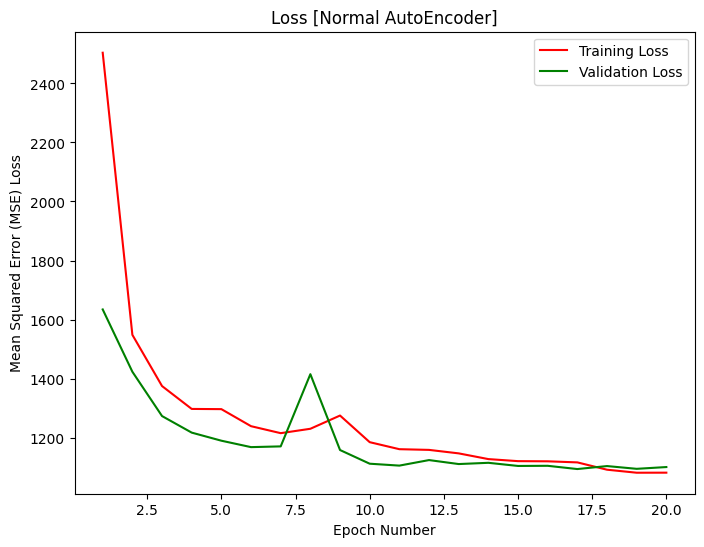

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_normal_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_normal_ae,label="Validation Loss",color="green")

plt.title("Loss [Normal AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("Mean Squared Error (MSE) Loss")

plt.legend()
plt.show()

# **1.4. Testing**

In [ ]:

test_loss_normal_ae, test_original_examples_normal_ae, test_reconstructed_examples_normal_ae = test(testloader,normal_autoencoder,
                                                                                                    loss_function_normal_ae)

print()
print("Test Loss     : {}".format(test_loss_normal_ae))


Test Loss     : 1097.2318567083787


# **1.5. Classification**

In [ ]:

classifier = Classifier(in_features = 30).to(device)

print(classifier)

Classifier(
  (FullyConnectedBlock): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
)


In [ ]:

learning_rate = 0.001

optimizer_classifier = optim.Adam(classifier.parameters(), lr = learning_rate)

loss_function_classifier = nn.CrossEntropyLoss()

epochs = 10

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_classifier)
print()
print("Loss Function : ",loss_function_classifier)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  CrossEntropyLoss()

Epochs        :  10


In [ ]:

val_loss_classifier_normal_ae = np.zeros(epochs)
val_accuracy_classifier_normal_ae = np.zeros(epochs)
train_loss_classifier_normal_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_classifier(trainloader,classifier,normal_autoencoder,optimizer_classifier,loss_function_classifier)
  train_loss_classifier_normal_ae[epoch] = ith_average_train_loss

  ith_average_val_loss, ith_average_val_accuracy = validation_classifier(valloader,classifier,normal_autoencoder,loss_function_classifier)
  val_loss_classifier_normal_ae[epoch] = ith_average_val_loss
  val_accuracy_classifier_normal_ae[epoch] = ith_average_val_accuracy

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()
  print("Validation Accuracy : {} %".format(ith_average_val_accuracy*100))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/10]

Training Loss       : 1.6841814237663604

Validation Loss     : 1.3362239051696867

Validation Accuracy : 56.41957364341085 %

-----------------------------------------------------

Epoch [2/10]

Training Loss       : 1.260371605247182

Validation Loss     : 1.2242243615693824

Validation Accuracy : 60.58624031007752 %

-----------------------------------------------------

Epoch [3/10]

Training Loss       : 1.1530562655793295

Validation Loss     : 1.1480874356835387

Validation Accuracy : 61.89437984496124 %

-----------------------------------------------------

Epoch [4/10]

Training Loss       : 1.078762671936698

Validation Loss     : 1.1295253330653952

Validation Accuracy : 63.856589147286826 %

-----------------------------------------------------

Epoch [5/10]

Training Loss       : 1.0270078904175943

Validation Loss     : 1.1318170960790428

Validation Accuracy : 62.354651162790695 %

--------------------

In [ ]:
torch.save(classifier.state_dict(), 'classifier_weights.pth')
print("Classifier weights saved successfully!")

Classifier weights saved successfully!


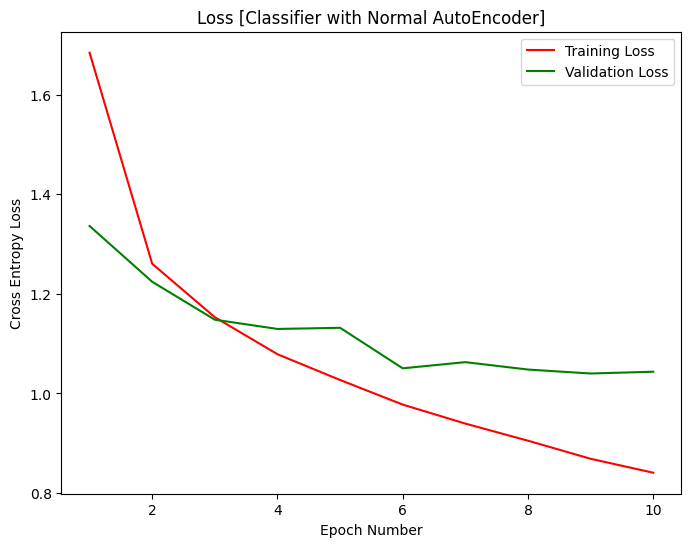

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_classifier_normal_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_classifier_normal_ae,label="Validation Loss",color="green")

plt.title("Loss [Classifier with Normal AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy Loss")

plt.legend()

plt.show()

In [ ]:
test_loss_classifier_normal_ae, test_accuracy_classifier_normal_ae, \
test_ground_truths_classifier_normal_ae, test_predictions_classifier_normal_ae = test_classifier(testloader,classifier,
                                                                                                 normal_autoencoder,loss_function_classifier)

print()
print("Test Loss     : {}".format(test_loss_classifier_normal_ae))
print()
print("Test Accuracy : {} %".format(test_accuracy_classifier_normal_ae*100))


Test Loss     : 1.0105569701093111

Test Accuracy : 67.12693798449612 %


In [ ]:
def flatten(list_of_lists):

  try:

    flattened_list = []

    for list_ in list_of_lists:

      flattened_list.extend(list_)

    return flattened_list

  except:

    return list_of_lists

test_ground_truths_classifier_normal_ae = flatten(test_ground_truths_classifier_normal_ae)

# **1.6. Visualization**

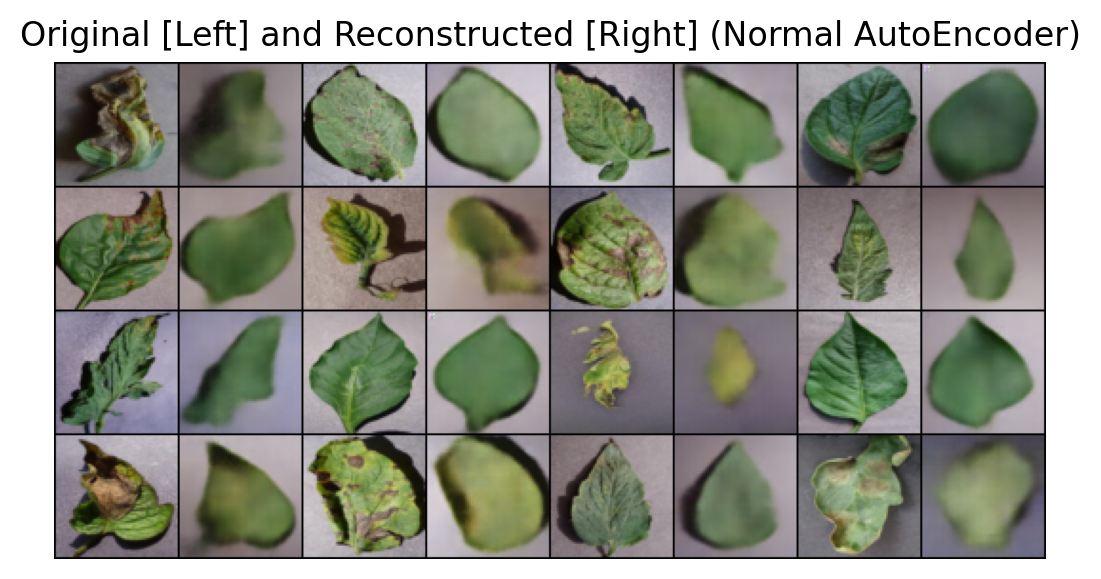

In [ ]:
imgs = torch.stack([test_original_examples_normal_ae.view(-1, 3, 64, 64), test_reconstructed_examples_normal_ae.view(-1, 3, 64, 64)],dim=1).flatten(0,1)

grid = make_grid(imgs, nrow = 8, normalize = True, padding = 1)

grid = grid.permute(1, 2, 0)

plt.figure(dpi = 200)

plt.title('Original [Left] and Reconstructed [Right] (Normal AutoEncoder)')

plt.imshow(grid)

plt.axis('off')

plt.show()

image to classification

In [ ]:
class_name = [
    'Tomato__Target_Spot',                            # 0
    'Tomato_Early_blight',                            # 1
    'Tomato_Leaf_Mold',                               # 2
    'Tomato_Bacterial_spot',                          # 3
    'Potato___Early_blight',                          # 4
    'Tomato_Spider_mites_Two_spotted_spider_mite',    # 5
    'Tomato_Septoria_leaf_spot',                      # 6
    'Tomato_healthy',                                 # 7
    'Potato___healthy',                               # 8
    'Tomato__Tomato_mosaic_virus',                    # 9
    'Tomato__Tomato_YellowLeaf__Curl_Virus',          # 10
    'Pepper__bell___healthy',                         # 11
    'Potato___Late_blight',                           # 12
    'Pepper__bell___Bacterial_spot',                  # 13
    'Tomato_Late_blight'                              # 14
]

image_path = "potato_healthy.jpg"
img = Image.open(image_path).convert("RGB")

normal_autoencoder.load_state_dict(torch.load('normal_autoencoder_weights.pth'))
classifier.load_state_dict(torch.load('classifier_weights.pth'))

normal_autoencoder.eval()
classifier.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
input_image = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    encoded_feature, _ = normal_autoencoder(input_image)

with torch.no_grad():
    output = classifier(encoded_feature)
    predicted_class = torch.argmax(output, dim=1).item()

print("Predicted Class:", predicted_class)
print(f"Predicted class: {class_name[predicted_class]}")

Predicted Class: 11
Predicted class: Pepper__bell___healthy


# **2. Variational AutoEncoder**

# **2.1. Architecture**

In [ ]:
class VariationalAutoEncoder(nn.Module):

  def __init__(self, in_channels):

    super(VariationalAutoEncoder,self).__init__()

    self.Conv1_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = 100,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 100)
    )

    self.Conv2_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 100,
                  out_channels = 150,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 150)
    )

    self.Conv3_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 150,
                  out_channels = 150,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )

    self.Conv4_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 150,
                  out_channels = 200,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 200)
    )

    self.Conv5_Encoder = nn.Sequential(
        nn.Conv2d(in_channels = 200,
                  out_channels = 200,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 200)
    )


    self.Encoder = nn.Sequential(
        self.Conv1_Encoder,
        self.Conv2_Encoder,
        self.Conv3_Encoder,
        self.Conv4_Encoder,
        self.Conv5_Encoder,
        nn.Flatten()
    )

    self.mean = nn.Linear(200 * 4 * 4, 30)
    self.log_var = nn.Linear(200 * 4 * 4, 30)


    self.Conv1_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  200,
                           out_channels =  200,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 200)
    )

    self.Conv2_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  200,
                           out_channels = 150,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )

    self.Conv3_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  150,
                           out_channels = 150,
                           kernel_size = 3,
                           padding = 1,
                           stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 150)
    )

    self.Conv4_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  150,
                           out_channels = 100,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 100)
    )

    self.Conv5_Decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels =  100,
                           out_channels = in_channels,
                           kernel_size = 3,
                           padding = 1,
                           output_padding = 1,
                           stride = 2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = in_channels)
    )


    self.Decoder = nn.Sequential(
        nn.Linear(30, 200*4*4),
        nn.Unflatten(1, (200,4,4)),
        self.Conv1_Decoder,
        self.Conv2_Decoder,
        self.Conv3_Decoder,
        self.Conv4_Decoder,
        self.Conv5_Decoder,
        nn.Sigmoid()
    )

    self.flatten = nn.Flatten()

  def reparameterization_trick(self, mean, log_var):


    epsilon = torch.randn_like(log_var).to(mean.device)

    z = mean + log_var * epsilon

    return z

  def forward(self,x):


    x = self.Conv1_Encoder(x)
    x_r = self.Conv2_Encoder(x)
    x = self.Conv3_Encoder(x_r)
    x = self.Conv4_Encoder(x + x_r)
    x = self.Conv5_Encoder(x)
    x = self.flatten(x)

    mean = self.mean(x)
    log_var = self.log_var(x)

    encoded = self.reparameterization_trick(mean, torch.exp(0.5 * log_var))

    decoded = self.Decoder(encoded)

    return encoded, decoded, mean, log_var

# **2.2. Setup**

In [ ]:
def train_vae(dataloader,model,optimizer,loss_function):

  num_batches = len(dataloader)

  model.train(True)

  train_loss = 0

  for batch, (X,y) in enumerate(dataloader):

    optimizer.zero_grad()

    X,y = X.to(device), y.to(device)


    code, reconstruction, mean, log_var = model(X)

    loss = loss_function(reconstruction,X,mean,log_var)
    train_loss += loss.item()

    loss.backward()

    optimizer.step()

  train_loss = train_loss / num_batches

  return train_loss

In [ ]:
def validation_vae(dataloader,model,loss_function):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)

  model.eval()

  val_loss = 0

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):


      X,y = X.to(device), y.to(device)


      code, reconstruction, mean, log_var = model(X)

      loss = loss_function(reconstruction,X,mean,log_var)
      val_loss += loss.item()

  val_loss = val_loss / num_batches

  return val_loss

In [ ]:
def test_vae(dataloader,model,loss_function):

  num_batches = len(dataloader)

  size = len(dataloader.dataset)

  model.eval()

  test_loss = 0

  with torch.no_grad():

    for batch, (X,y) in enumerate(dataloader):


      X,y = X.to(device), y.to(device)


      code, reconstruction, mean, log_var = model(X)

      loss = loss_function(reconstruction,X,mean,log_var)
      test_loss += loss.item()


  test_loss = test_loss / num_batches

  test_reconstructed_examples = reconstruction.cpu()

  test_original_examples = X.cpu()

  return test_loss, test_original_examples, test_reconstructed_examples

In [ ]:

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size())

torch.Size([16, 3, 64, 64])


In [ ]:

variational_autoencoder = VariationalAutoEncoder(in_channels = 3).to(device)

In [ ]:

learning_rate = 0.001

optimizer_variational_ae = optim.Adam(variational_autoencoder.parameters(), lr = learning_rate)

def ELBO(reconstruction, X, mean, log_var):

  reconstruction_loss = F.mse_loss(reconstruction, X, reduction = 'sum')
  KL_Divergence       = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

  return reconstruction_loss + KL_Divergence

loss_function_variational_ae = ELBO

epochs = 20

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_variational_ae)
print()
print("Loss Function : ",loss_function_variational_ae)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  <function ELBO at 0x7b2bb85ccf40>

Epochs        :  20


# **2.3. Training and Validation**

In [ ]:

val_loss_variational_ae = np.zeros(epochs)
train_loss_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_vae(trainloader,variational_autoencoder,optimizer_variational_ae,loss_function_variational_ae)
  train_loss_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss = validation_vae(valloader,variational_autoencoder,loss_function_variational_ae)
  val_loss_variational_ae[epoch] = ith_average_val_loss

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/20]

Training Loss       : 3432.3806791083757

Validation Loss     : 3126.255440172299

-----------------------------------------------------

Epoch [2/20]

Training Loss       : 2550.167630296653

Validation Loss     : 2287.4741239325945

-----------------------------------------------------

Epoch [3/20]

Training Loss       : 2290.5819012940083

Validation Loss     : 2284.0882270280704

-----------------------------------------------------

Epoch [4/20]

Training Loss       : 2282.5620971995113

Validation Loss     : 2122.0489814226016

-----------------------------------------------------

Epoch [5/20]

Training Loss       : 2141.706819125232

Validation Loss     : 2112.1919110911763

-----------------------------------------------------

Epoch [6/20]

Training Loss       : 2092.0452437684207

Validation Loss     : 2035.2253228712452

-----------------------------------------------------

Epoch [7/20]

Training Loss   

In [ ]:
torch.save(variational_autoencoder.state_dict(), "vae_weights.pth")

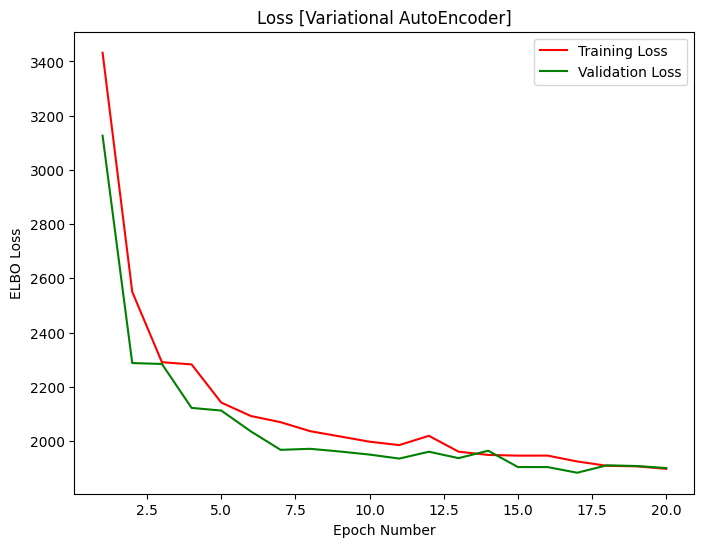

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("ELBO Loss")

plt.legend()

plt.show()

# **2.4. Testing**

In [ ]:

test_loss_variational_ae, test_original_examples_variational_ae, test_reconstructed_examples_variational_ae = test_vae(testloader,variational_autoencoder,
                                                                                                                       loss_function_variational_ae)

print()
print("Test Loss     : {}".format(test_loss_variational_ae))


Test Loss     : 1897.250188310017


# **2.5. Classification**

In [ ]:

classifier = Classifier(in_features = 30).to(device)

print(classifier)

Classifier(
  (FullyConnectedBlock): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
)


In [ ]:

learning_rate = 0.001

optimizer_classifier = optim.Adam(classifier.parameters(), lr = learning_rate)

loss_function_classifier = nn.CrossEntropyLoss()

epochs = 10

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_classifier)
print()
print("Loss Function : ",loss_function_classifier)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  CrossEntropyLoss()

Epochs        :  10


In [ ]:

val_loss_classifier_variational_ae = np.zeros(epochs)
val_accuracy_classifier_variational_ae = np.zeros(epochs)
train_loss_classifier_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_classifier(trainloader,classifier,variational_autoencoder,optimizer_classifier,loss_function_classifier,ae_type = 'vae')
  train_loss_classifier_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss, ith_average_val_accuracy = validation_classifier(valloader,classifier,variational_autoencoder,loss_function_classifier,ae_type = 'vae')
  val_loss_classifier_variational_ae[epoch] = ith_average_val_loss
  val_accuracy_classifier_variational_ae[epoch] = ith_average_val_accuracy

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()
  print("Validation Accuracy : {} %".format(ith_average_val_accuracy*100))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/10]

Training Loss       : 1.6425856478916583

Validation Loss     : 1.3138059245985607

Validation Accuracy : 57.122093023255815 %

-----------------------------------------------------

Epoch [2/10]

Training Loss       : 1.2348208812472123

Validation Loss     : 1.1891452824884607

Validation Accuracy : 61.627906976744185 %

-----------------------------------------------------

Epoch [3/10]

Training Loss       : 1.1197947051173958

Validation Loss     : 1.0929482700519784

Validation Accuracy : 64.60755813953489 %

-----------------------------------------------------

Epoch [4/10]

Training Loss       : 1.049109975496928

Validation Loss     : 1.0630251402540725

Validation Accuracy : 65.6734496124031 %

-----------------------------------------------------

Epoch [5/10]

Training Loss       : 1.0107379055146406

Validation Loss     : 1.0255017485036406

Validation Accuracy : 66.03682170542635 %

--------------------

In [ ]:
torch.save(classifier.state_dict(), "classifier_vae_weights.pth")


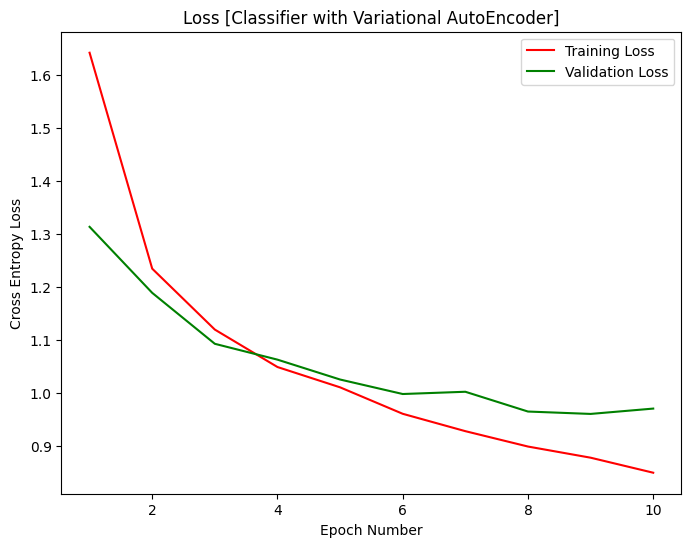

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_classifier_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_classifier_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Classifier with Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy Loss")

plt.legend()

plt.show()

In [ ]:

test_loss_classifier_variational_ae, test_accuracy_classifier_variational_ae, \
test_ground_truths_classifier_variational_ae, test_predictions_classifier_variational_ae = test_classifier(testloader,classifier,
                                                                                                           variational_autoencoder,loss_function_classifier,
                                                                                                           ae_type = 'vae')

print()
print("Test Loss     : {}".format(test_loss_classifier_variational_ae))
print()
print("Test Accuracy : {} %".format(test_accuracy_classifier_variational_ae*100))


Test Loss     : 0.9467517370863479

Test Accuracy : 68.24127906976744 %


In [ ]:

def flatten(list_of_lists):

  try:

    flattened_list = []

    for list_ in list_of_lists:

      flattened_list.extend(list_)

    return flattened_list

  except:

    return list_of_lists

test_ground_truths_classifier_variational_ae = flatten(test_ground_truths_classifier_variational_ae)

# **2.6. Visualization**

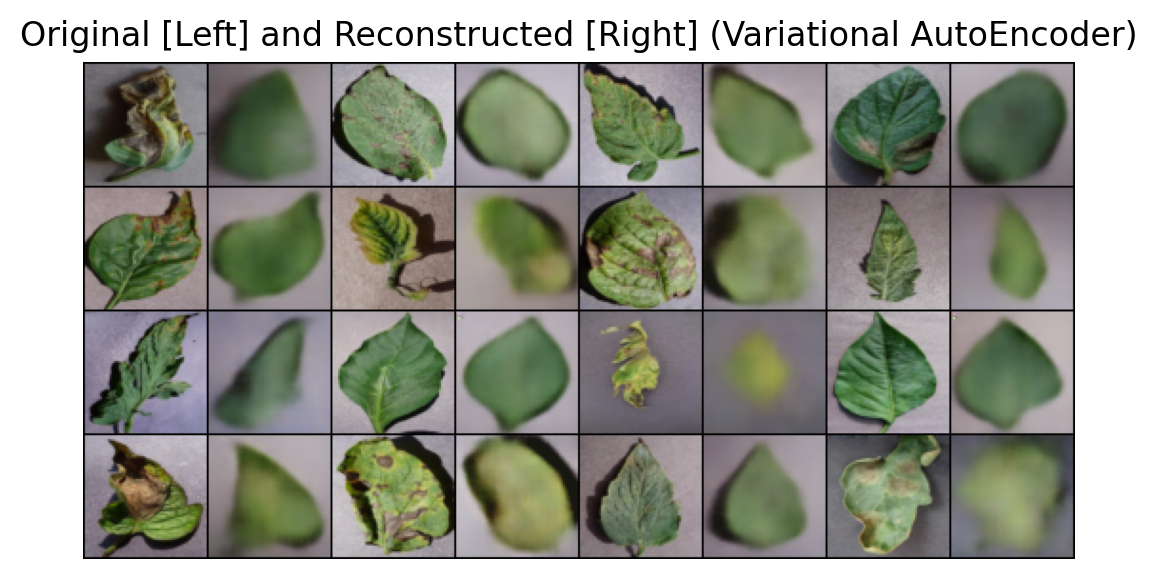

In [ ]:

imgs = torch.stack([test_original_examples_variational_ae.view(-1, 3, 64, 64), test_reconstructed_examples_variational_ae.view(-1, 3, 64, 64)],dim=1).flatten(0,1)

grid = make_grid(imgs, nrow = 8, normalize = True, padding = 1)

grid = grid.permute(1, 2, 0)

plt.figure(dpi = 200)

plt.title('Original [Left] and Reconstructed [Right] (Variational AutoEncoder)')

plt.imshow(grid)

plt.axis('off')

plt.show()

#Experiment-2

## **Preprocessing-2**

In [ ]:
import zipfile
import pandas as pd

zip_path = "/content/archive (4).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
labels_list = []
valid_images_to_continue_with = []
invalid_images = 0
categories_name = {}

def check_valid_images_all_folders(directory):
    global invalid_images
    for i, folder in enumerate(os.listdir(directory)):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            categories_name[folder] = 0
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        invalid_images += 1
                    else:
                        valid_images_to_continue_with.append(img)
                        labels_list.append(folder)
                        categories_name[folder] += 1
                except:
                    invalid_images += 1

check_valid_images_all_folders('/content/PlantVillage')

In [ ]:

label_mapping = {label: i for i, label in enumerate(set(labels_list))}
labels_list_int = [label_mapping[label] for label in labels_list]

In [ ]:
print(label_mapping)

{'Tomato__Tomato_YellowLeaf__Curl_Virus': 0, 'Tomato__Target_Spot': 1, 'Tomato_Bacterial_spot': 2, 'Tomato_Late_blight': 3, 'Tomato_Septoria_leaf_spot': 4, 'Pepper__bell___healthy': 5, 'Pepper__bell___Bacterial_spot': 6, 'Tomato_Spider_mites_Two_spotted_spider_mite': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_healthy': 9, 'Potato___Early_blight': 10, 'Potato___Late_blight': 11, 'Tomato__Tomato_mosaic_virus': 12, 'Tomato_Early_blight': 13, 'Potato___healthy': 14}


In [ ]:

class EdgeBoostTransform:
    def __call__(self, image):
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        edges = cv2.Laplacian(gray, cv2.CV_64F)
        edges = np.uint8(np.absolute(edges))
        edge_3ch = cv2.merge([edges, edges, edges])

        blended = cv2.addWeighted(image_np, 0.8, edge_3ch, 0.2, 0)

        return transforms.ToTensor()(blended)

transform = transforms.Compose([
    EdgeBoostTransform(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [ ]:
dataset = PlantVillageDataset(valid_images_to_continue_with, labels_list_int, transform=transform)
indices = list(range(len(dataset)))
train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 60-20-20

In [ ]:
trainloader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
valloader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)
testloader = DataLoader(Subset(dataset, test_idx), batch_size=16, shuffle=False)

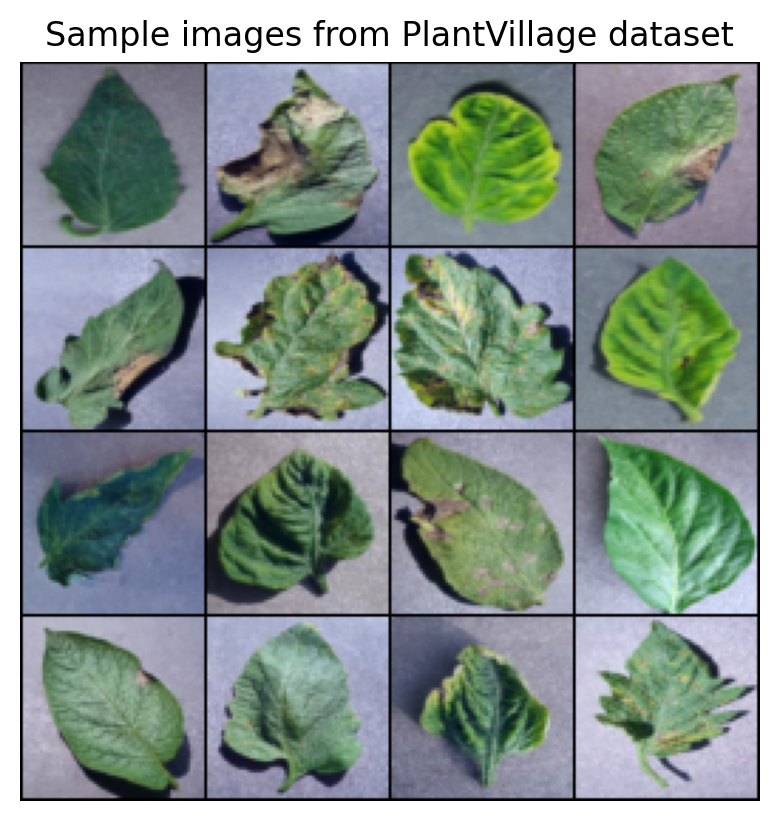

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = make_grid(images[:16], nrow=4, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)

plt.figure(dpi=200)
plt.title("Sample images from PlantVillage dataset")
plt.imshow(grid)
plt.axis('off')
plt.show()

## **2. Variational AutoEncoder**

In [ ]:

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size())

torch.Size([16, 3, 64, 64])


In [ ]:

variational_autoencoder = VariationalAutoEncoder(in_channels = 3).to(device)

In [ ]:

learning_rate = 0.001

optimizer_variational_ae = optim.Adam(variational_autoencoder.parameters(), lr = learning_rate)

def ELBO(reconstruction, X, mean, log_var):

  reconstruction_loss = F.mse_loss(reconstruction, X, reduction = 'sum')
  KL_Divergence       = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

  return reconstruction_loss + KL_Divergence

loss_function_variational_ae = ELBO

epochs = 20

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_variational_ae)
print()
print("Loss Function : ",loss_function_variational_ae)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  <function ELBO at 0x7c7900ac4400>

Epochs        :  20


### **2.3. Training and Validation**

In [ ]:

val_loss_variational_ae = np.zeros(epochs)
train_loss_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_vae(trainloader,variational_autoencoder,optimizer_variational_ae,loss_function_variational_ae)
  train_loss_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss = validation_vae(valloader,variational_autoencoder,loss_function_variational_ae)
  val_loss_variational_ae[epoch] = ith_average_val_loss

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/20]

Training Loss       : 139413.7231508398

Validation Loss     : 116639.74609375

-----------------------------------------------------

Epoch [2/20]

Training Loss       : 109701.25700500645

Validation Loss     : 98319.6070433624

-----------------------------------------------------

Epoch [3/20]

Training Loss       : 97925.2837128553

Validation Loss     : 90856.6664395591

-----------------------------------------------------

Epoch [4/20]

Training Loss       : 92335.04082384528

Validation Loss     : 87103.92058805717

-----------------------------------------------------

Epoch [5/20]

Training Loss       : 89239.54204013242

Validation Loss     : 85851.49860707365

-----------------------------------------------------

Epoch [6/20]

Training Loss       : 87464.99170300388

Validation Loss     : 84505.81150072675

-----------------------------------------------------

Epoch [7/20]

Training Loss       : 86296.1

In [ ]:
torch.save(variational_autoencoder.state_dict(), "vae_weights.pth")

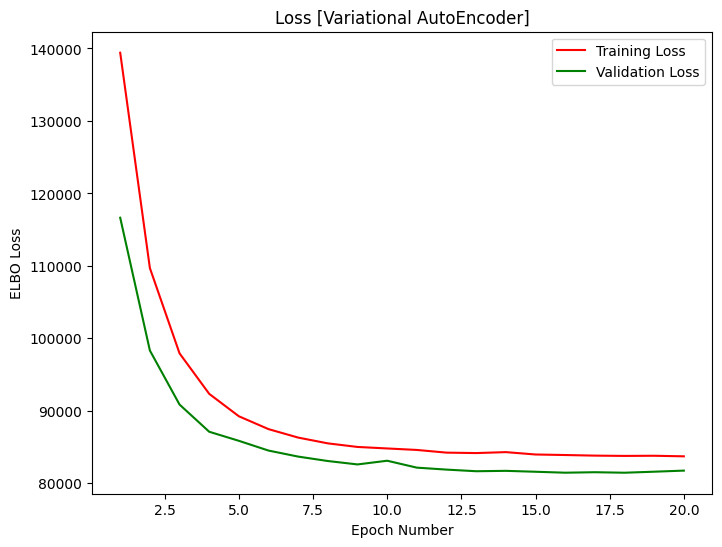

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("ELBO Loss")

plt.legend()

plt.show()

### **2.4. Testing**

In [ ]:

test_loss_variational_ae, test_original_examples_variational_ae, test_reconstructed_examples_variational_ae = test_vae(testloader,variational_autoencoder,
                                                                                                                       loss_function_variational_ae)

print()
print("Test Loss     : {}".format(test_loss_variational_ae))


Test Loss     : 82644.4163638566


### **2.5. Classification**

In [ ]:

classifier = Classifier(in_features = 30).to(device)

print(classifier)

Classifier(
  (FullyConnectedBlock): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
)


In [ ]:

learning_rate = 0.001

optimizer_classifier = optim.Adam(classifier.parameters(), lr = learning_rate)

loss_function_classifier = nn.CrossEntropyLoss()

epochs = 10

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_classifier)
print()
print("Loss Function : ",loss_function_classifier)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  CrossEntropyLoss()

Epochs        :  10


In [ ]:

val_loss_classifier_variational_ae = np.zeros(epochs)
val_accuracy_classifier_variational_ae = np.zeros(epochs)
train_loss_classifier_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_classifier(trainloader,classifier,variational_autoencoder,optimizer_classifier,loss_function_classifier,ae_type = 'vae')
  train_loss_classifier_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss, ith_average_val_accuracy = validation_classifier(valloader,classifier,variational_autoencoder,loss_function_classifier,ae_type = 'vae')
  val_loss_classifier_variational_ae[epoch] = ith_average_val_loss
  val_accuracy_classifier_variational_ae[epoch] = ith_average_val_accuracy

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()
  print("Validation Accuracy : {} %".format(ith_average_val_accuracy*100))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/10]

Training Loss       : 12164659733392.238

Validation Loss     : 1.5217158233010493

Validation Accuracy : 49.97577519379845 %

-----------------------------------------------------

Epoch [2/10]

Training Loss       : 1951667959613.6562

Validation Loss     : 1.457997904267422

Validation Accuracy : 52.349806201550386 %

-----------------------------------------------------

Epoch [3/10]

Training Loss       : 524305080681.2231

Validation Loss     : 1.4238982808220295

Validation Accuracy : 52.76162790697675 %

-----------------------------------------------------

Epoch [4/10]

Training Loss       : 2944267363681.296

Validation Loss     : 1.406252522801244

Validation Accuracy : 53.92441860465116 %

-----------------------------------------------------

Epoch [5/10]

Training Loss       : 1.3099481880818842

Validation Loss     : 1.3586436919001645

Validation Accuracy : 54.84496124031008 %

-----------------------

In [ ]:
torch.save(classifier.state_dict(), "classifier_vae_weights.pth")

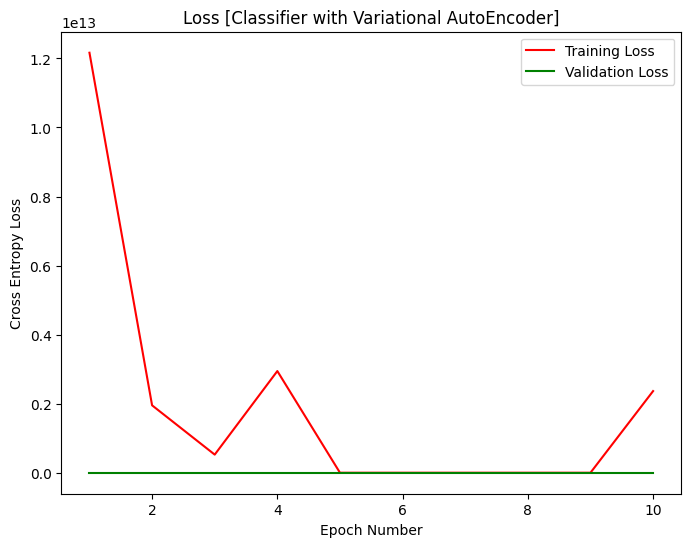

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_classifier_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_classifier_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Classifier with Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy Loss")

plt.legend()

plt.show()

In [ ]:

test_loss_classifier_variational_ae, test_accuracy_classifier_variational_ae, \
test_ground_truths_classifier_variational_ae, test_predictions_classifier_variational_ae = test_classifier(testloader,classifier,
                                                                                                           variational_autoencoder,loss_function_classifier,
                                                                                                           ae_type = 'vae')

print()
print("Test Loss     : {}".format(test_loss_classifier_variational_ae))
print()
print("Test Accuracy : {} %".format(test_accuracy_classifier_variational_ae*100))


Test Loss     : 1.2964877474677654

Test Accuracy : 56.66182170542635 %


In [ ]:
test_ground_truths_classifier_variational_ae = flatten(test_ground_truths_classifier_variational_ae)

### **2.6. Visualization**

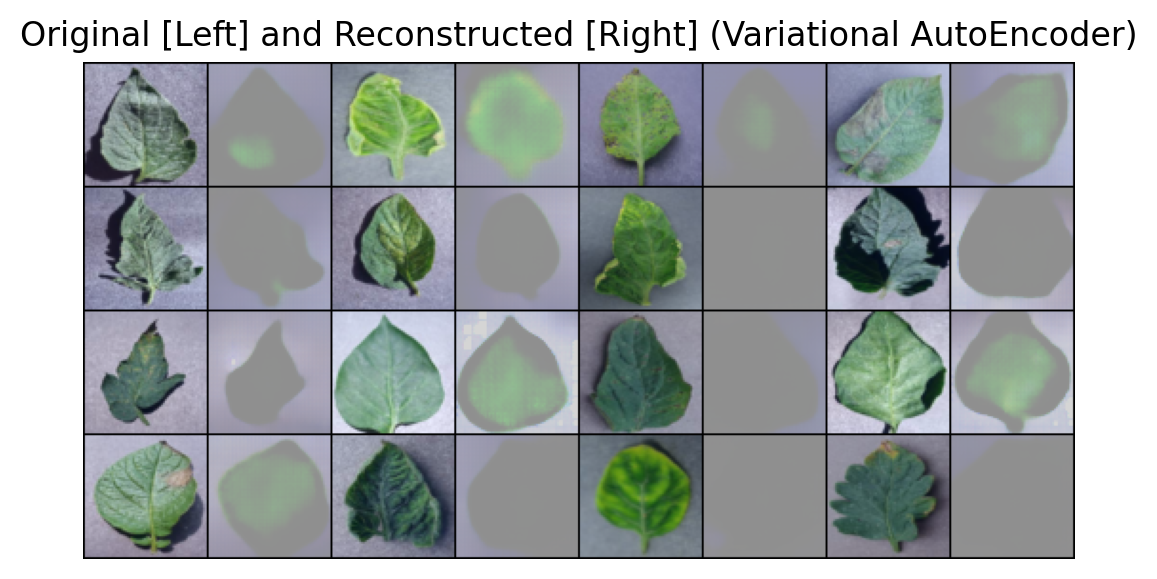

In [ ]:
imgs = torch.stack([test_original_examples_variational_ae.view(-1, 3, 64, 64), test_reconstructed_examples_variational_ae.view(-1, 3, 64, 64)],dim=1).flatten(0,1)

grid = make_grid(imgs, nrow = 8, normalize = True, padding = 1)

grid = grid.permute(1, 2, 0)

plt.figure(dpi = 200)

plt.title('Original [Left] and Reconstructed [Right] (Variational AutoEncoder)')

plt.imshow(grid)

plt.axis('off')

plt.show()

#Experiment-3

## **Preprocessing-2**

In [ ]:
import cv2
import numpy as np
from torchvision import transforms

class EdgeBoostTransform:
    def __call__(self, image):
        image_np = np.array(image)
        image_np = cv2.bilateralFilter(image_np, d=9, sigmaColor=75, sigmaSpace=75)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        edges = cv2.Laplacian(gray, cv2.CV_64F)
        edges = np.uint8(np.absolute(edges))
        edge_3ch = cv2.merge([edges, edges, edges])
        blended = cv2.addWeighted(image_np, 0.8, edge_3ch, 0.2, 0)
        return transforms.ToTensor()(blended)

transform = transforms.Compose([
    EdgeBoostTransform(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [ ]:
dataset = PlantVillageDataset(valid_images_to_continue_with, labels_list_int, transform=transform)
indices = list(range(len(dataset)))
train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 60-20-20

In [ ]:
trainloader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
valloader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)
testloader = DataLoader(Subset(dataset, test_idx), batch_size=16, shuffle=False)

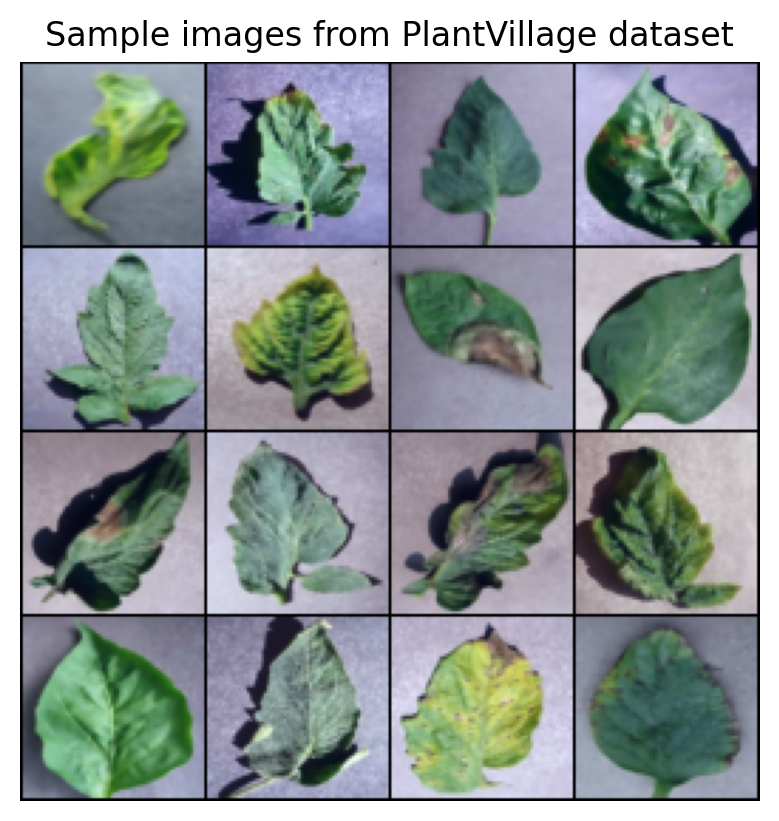

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = make_grid(images[:16], nrow=4, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)

plt.figure(dpi=200)
plt.title("Sample images from PlantVillage dataset")
plt.imshow(grid)
plt.axis('off')
plt.show()

## **2. Variational AutoEncoder**

In [ ]:

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size())

torch.Size([16, 3, 64, 64])


In [ ]:

variational_autoencoder = VariationalAutoEncoder(in_channels = 3).to(device)

In [ ]:

learning_rate = 0.001

optimizer_variational_ae = optim.Adam(variational_autoencoder.parameters(), lr = learning_rate)

def ELBO(reconstruction, X, mean, log_var):

  reconstruction_loss = F.mse_loss(reconstruction, X, reduction = 'sum')
  KL_Divergence       = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

  return reconstruction_loss + KL_Divergence

loss_function_variational_ae = ELBO

epochs = 20

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_variational_ae)
print()
print("Loss Function : ",loss_function_variational_ae)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  <function ELBO at 0x7c79786eede0>

Epochs        :  20


### **2.3. Training and Validation**

In [ ]:

val_loss_variational_ae = np.zeros(epochs)
train_loss_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_vae(trainloader,variational_autoencoder,optimizer_variational_ae,loss_function_variational_ae)
  train_loss_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss = validation_vae(valloader,variational_autoencoder,loss_function_variational_ae)
  val_loss_variational_ae[epoch] = ith_average_val_loss

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/20]

Training Loss       : 156162.3011143411

Validation Loss     : 133924.02292272286

-----------------------------------------------------

Epoch [2/20]

Training Loss       : 122736.16228601421

Validation Loss     : 110180.84299297481

-----------------------------------------------------

Epoch [3/20]

Training Loss       : 109021.26066900839

Validation Loss     : 102721.53294573643

-----------------------------------------------------

Epoch [4/20]

Training Loss       : 102318.24117813307

Validation Loss     : 97760.26274830426

-----------------------------------------------------

Epoch [5/20]

Training Loss       : 98580.71912346577

Validation Loss     : 95016.63674903101

-----------------------------------------------------

Epoch [6/20]

Training Loss       : 96322.57372920704

Validation Loss     : 93153.14110949612

-----------------------------------------------------

Epoch [7/20]

Training Loss      

In [ ]:
torch.save(variational_autoencoder.state_dict(), "vae_weights.pth")

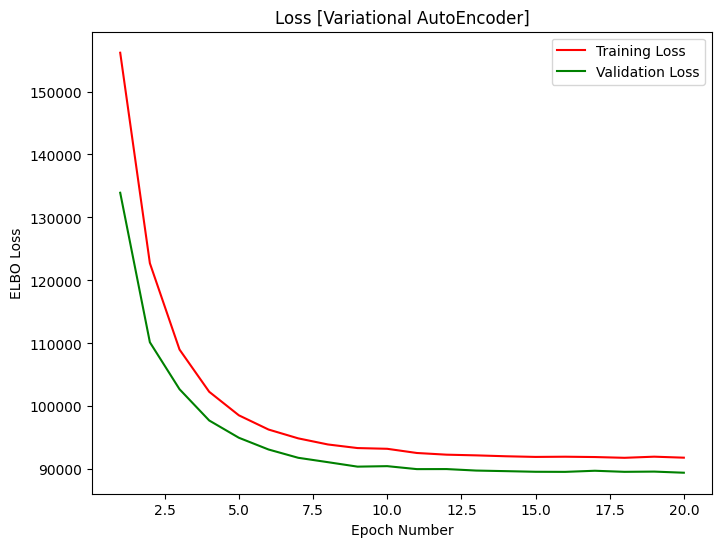

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("ELBO Loss")

plt.legend()

plt.show()

### **2.4. Testing**

In [ ]:

test_loss_variational_ae, test_original_examples_variational_ae, test_reconstructed_examples_variational_ae = test_vae(testloader,variational_autoencoder,
                                                                                                                       loss_function_variational_ae)

print()
print("Test Loss     : {}".format(test_loss_variational_ae))


Test Loss     : 90355.79692042152


### **2.5. Classification**

In [ ]:

classifier = Classifier(in_features = 30).to(device)

print(classifier)

Classifier(
  (FullyConnectedBlock): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
)


In [ ]:

learning_rate = 0.001

optimizer_classifier = optim.Adam(classifier.parameters(), lr = learning_rate)

loss_function_classifier = nn.CrossEntropyLoss()

epochs = 10

print("Learning Rate : ", learning_rate)
print()
print("Optimizer     : ", optimizer_classifier)
print()
print("Loss Function : ",loss_function_classifier)
print()
print("Epochs        : ", epochs)

Learning Rate :  0.001

Optimizer     :  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Loss Function :  CrossEntropyLoss()

Epochs        :  10


In [ ]:

val_loss_classifier_variational_ae = np.zeros(epochs)
val_accuracy_classifier_variational_ae = np.zeros(epochs)
train_loss_classifier_variational_ae = np.zeros(epochs)

for epoch in range(epochs):

  ith_average_train_loss = train_classifier(trainloader,classifier,variational_autoencoder,optimizer_classifier,loss_function_classifier,ae_type = 'vae')
  train_loss_classifier_variational_ae[epoch] = ith_average_train_loss

  ith_average_val_loss, ith_average_val_accuracy = validation_classifier(valloader,classifier,variational_autoencoder,loss_function_classifier,ae_type = 'vae')
  val_loss_classifier_variational_ae[epoch] = ith_average_val_loss
  val_accuracy_classifier_variational_ae[epoch] = ith_average_val_accuracy

  print("-----------------------------------------------------")
  print()
  print("Epoch [{}/{}]".format(epoch+1,epochs))
  print()
  print("Training Loss       : {}".format(ith_average_train_loss))
  print()
  print("Validation Loss     : {}".format(ith_average_val_loss))
  print()
  print("Validation Accuracy : {} %".format(ith_average_val_accuracy*100))
  print()

print("-----------------------------------------------------")

-----------------------------------------------------

Epoch [1/10]

Training Loss       : 1.7667500430607364

Validation Loss     : 1.5175722853619924

Validation Accuracy : 50.48449612403101 %

-----------------------------------------------------

Epoch [2/10]

Training Loss       : 1.4006279553707872

Validation Loss     : 1.3729707947535108

Validation Accuracy : 55.30523255813954 %

-----------------------------------------------------

Epoch [3/10]

Training Loss       : 1.286558250740209

Validation Loss     : 1.2927723427613576

Validation Accuracy : 57.55813953488372 %

-----------------------------------------------------

Epoch [4/10]

Training Loss       : 1.2089458804490953

Validation Loss     : 1.2743083917817404

Validation Accuracy : 58.55135658914728 %

-----------------------------------------------------

Epoch [5/10]

Training Loss       : 1.1567756763878412

Validation Loss     : 1.222816210153491

Validation Accuracy : 59.253875968992254 %

---------------------

In [ ]:
torch.save(classifier.state_dict(), "classifier_vae_weights.pth")

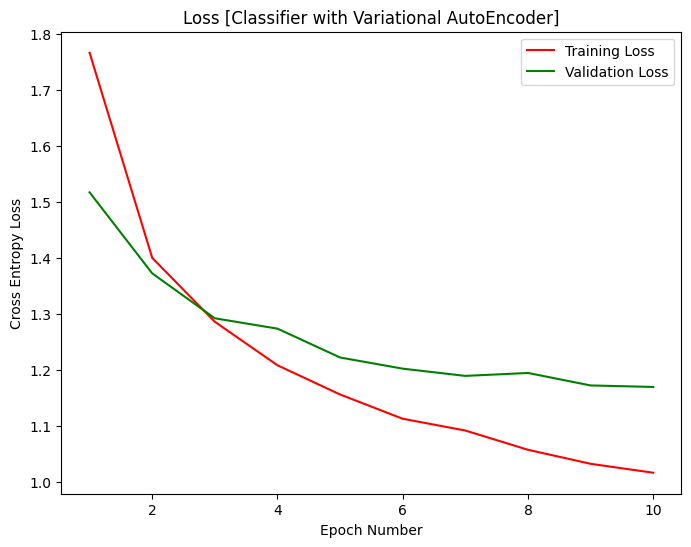

In [ ]:

fig, ax = plt.subplots(figsize=(8,6))

plt.plot([i for i in range(1,epochs+1)],train_loss_classifier_variational_ae,label="Training Loss",color="red")
plt.plot([i for i in range(1,epochs+1)],val_loss_classifier_variational_ae,label="Validation Loss",color="green")

plt.title("Loss [Classifier with Variational AutoEncoder]")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy Loss")

plt.legend()

plt.show()

In [ ]:

test_loss_classifier_variational_ae, test_accuracy_classifier_variational_ae, \
test_ground_truths_classifier_variational_ae, test_predictions_classifier_variational_ae = test_classifier(testloader,classifier,
                                                                                                           variational_autoencoder,loss_function_classifier,
                                                                                                           ae_type = 'vae')

print()
print("Test Loss     : {}".format(test_loss_classifier_variational_ae))
print()
print("Test Accuracy : {} %".format(test_accuracy_classifier_variational_ae*100))


Test Loss     : 1.1696171504120494

Test Accuracy : 61.531007751937985 %


In [ ]:

test_ground_truths_classifier_variational_ae = flatten(test_ground_truths_classifier_variational_ae)

### **2.6. Visualization**

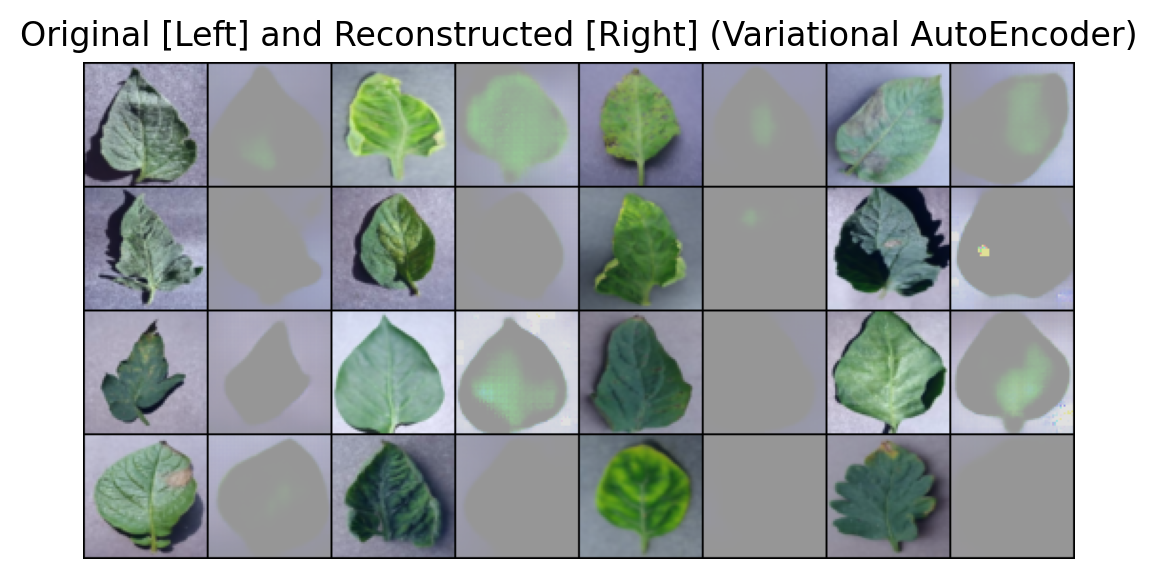

In [ ]:

imgs = torch.stack([test_original_examples_variational_ae.view(-1, 3, 64, 64), test_reconstructed_examples_variational_ae.view(-1, 3, 64, 64)],dim=1).flatten(0,1)

grid = make_grid(imgs, nrow = 8, normalize = True, padding = 1)

grid = grid.permute(1, 2, 0)

plt.figure(dpi = 200)

plt.title('Original [Left] and Reconstructed [Right] (Variational AutoEncoder)')

plt.imshow(grid)

plt.axis('off')

plt.show()